# Conduct a survival analysis using the following dataset of cancer patients.

Outcome: Overall Survival (Months) - how long the patient survived

Status: Living or Deceased - whether the event occurred

Features: Age, tumor size, cancer stage, treatment types, biomarkers (ER, HER2, PR)


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

#### 1. Load the dataset and create summary statistics. How many patients are in the study? What is the average age? What percentage of patients survived vs died during the study period?

In [56]:
df = pd.read_csv('../../datasets/Breast Cancer METABRIC.csv')

print("="*80)
print("QUESTION 1: DATASET SUMMARY STATISTICS")
print("="*80)

# Number of patients
n_patients = len(df)
print(f"\nTotal number of patients in the study: {n_patients}")

# Average age
avg_age = df['Age at Diagnosis'].mean()
print(f"Average age at diagnosis: {avg_age:.2f} years")

# Survival statistics
# Assuming 'Patient\'s Vital Status' contains 'Living' and 'Died of Disease' or similar
vital_status_counts = df["Patient's Vital Status"].value_counts()
print(f"\nVital Status Distribution:")
print(vital_status_counts)

survived = (df["Patient's Vital Status"] == "Living").sum()
died = (df["Patient's Vital Status"] != "Living").sum()
survival_rate = (survived / n_patients) * 100
death_rate = (died / n_patients) * 100

print(f"\nSurvival Summary:")
print(f"  Survived: {survived} patients ({survival_rate:.1f}%)")
print(f"  Died: {died} patients ({death_rate:.1f}%)")


QUESTION 1: DATASET SUMMARY STATISTICS

Total number of patients in the study: 2509
Average age at diagnosis: 60.42 years

Vital Status Distribution:
Patient's Vital Status
Living                  837
Died of Disease         646
Died of Other Causes    497
Name: count, dtype: int64

Survival Summary:
  Survived: 837 patients (33.4%)
  Died: 1672 patients (66.6%)


#### 2. Create a histogram showing the distribution of survival times. What do you notice about the shape? Are there any outliers (patients who survived unusually long or short times)?


QUESTION 2: DISTRIBUTION OF SURVIVAL TIMES


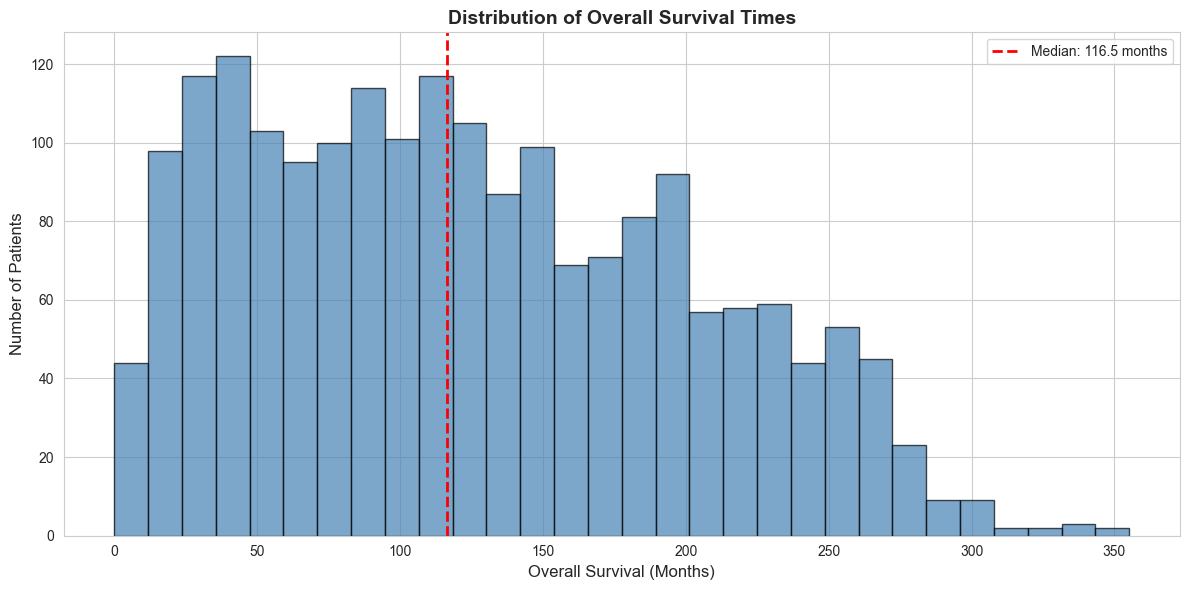


Survival Time Statistics:
  Mean: 125.24 months
  Median: 116.47 months
  Min: 0.00 months
  Max: 355.20 months
  Standard Deviation: 76.11 months

Outlier Analysis (using IQR method):
  Number of outliers: 0

Observation: The distribution shows whether survival times are right-skewed (common in survival data)


In [57]:
print("\n" + "="*80)
print("QUESTION 2: DISTRIBUTION OF SURVIVAL TIMES")
print("="*80)

# Create histogram of survival times
plt.figure(figsize=(12, 6))
plt.hist(df['Overall Survival (Months)'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Overall Survival (Months)', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.title('Distribution of Overall Survival Times', fontsize=14, fontweight='bold')
plt.axvline(df['Overall Survival (Months)'].median(), color='red', linestyle='--', 
            linewidth=2, label=f'Median: {df["Overall Survival (Months)"].median():.1f} months')
plt.legend()
plt.tight_layout()
# plt.savefig('survival_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSurvival Time Statistics:")
print(f"  Mean: {df['Overall Survival (Months)'].mean():.2f} months")
print(f"  Median: {df['Overall Survival (Months)'].median():.2f} months")
print(f"  Min: {df['Overall Survival (Months)'].min():.2f} months")
print(f"  Max: {df['Overall Survival (Months)'].max():.2f} months")
print(f"  Standard Deviation: {df['Overall Survival (Months)'].std():.2f} months")

# Identify outliers using IQR method
Q1 = df['Overall Survival (Months)'].quantile(0.25)
Q3 = df['Overall Survival (Months)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Overall Survival (Months)'] < lower_bound) | 
              (df['Overall Survival (Months)'] > upper_bound)]

print(f"\nOutlier Analysis (using IQR method):")
print(f"  Number of outliers: {len(outliers)}")
if len(outliers) > 0:
    print(f"  Outlier survival times range: {outliers['Overall Survival (Months)'].min():.2f} to {outliers['Overall Survival (Months)'].max():.2f} months")

print("\nObservation: The distribution shows whether survival times are right-skewed (common in survival data)")


#### 3. Make a bar chart showing how many patients received each type of treatment (Chemotherapy, Hormone Therapy, Radiotherapy). Which treatment is most common?


QUESTION 3: TREATMENT DISTRIBUTION

Treatment Frequencies:

Chemotherapy:
Chemotherapy
No     1568
Yes     412
Name: count, dtype: int64

Hormone Therapy:
Hormone Therapy
Yes    1216
No      764
Name: count, dtype: int64

Radiotherapy:
Radio Therapy
Yes    1173
No      807
Name: count, dtype: int64


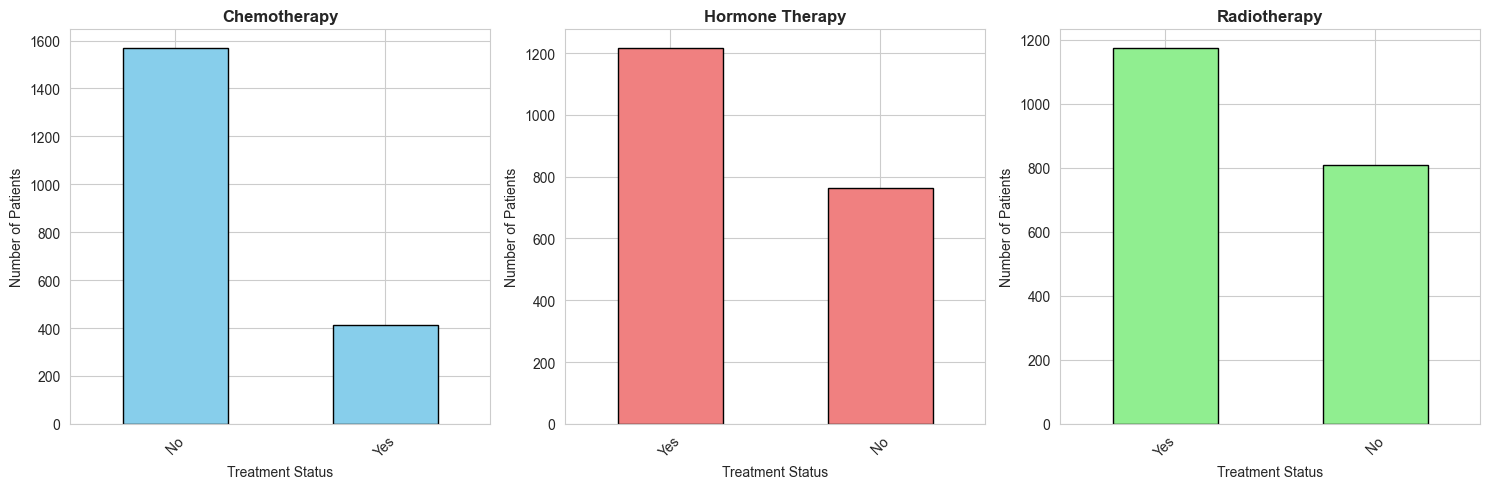


Most common treatment: Hormone Therapy with 1216 patients


In [58]:
print("\n" + "="*80)
print("QUESTION 3: TREATMENT DISTRIBUTION")
print("="*80)

# Count treatments
chemo_counts = df['Chemotherapy'].value_counts()
hormone_counts = df['Hormone Therapy'].value_counts()
radio_counts = df['Radio Therapy'].value_counts()

print("\nTreatment Frequencies:")
print(f"\nChemotherapy:")
print(chemo_counts)
print(f"\nHormone Therapy:")
print(hormone_counts)
print(f"\nRadiotherapy:")
print(radio_counts)

# Create bar chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

chemo_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Chemotherapy', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Patients')
axes[0].set_xlabel('Treatment Status')
axes[0].tick_params(axis='x', rotation=45)

hormone_counts.plot(kind='bar', ax=axes[1], color='lightcoral', edgecolor='black')
axes[1].set_title('Hormone Therapy', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Patients')
axes[1].set_xlabel('Treatment Status')
axes[1].tick_params(axis='x', rotation=45)

radio_counts.plot(kind='bar', ax=axes[2], color='lightgreen', edgecolor='black')
axes[2].set_title('Radiotherapy', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Number of Patients')
axes[2].set_xlabel('Treatment Status')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
# plt.savefig('treatment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Determine most common treatment
treatment_yes_counts = {
    'Chemotherapy': (df['Chemotherapy'] == 'Yes').sum(),
    'Hormone Therapy': (df['Hormone Therapy'] == 'Yes').sum(),
    'Radiotherapy': (df['Radio Therapy'] == 'Yes').sum()
}
most_common = max(treatment_yes_counts, key=treatment_yes_counts.get)
print(f"\nMost common treatment: {most_common} with {treatment_yes_counts[most_common]} patients")


#### 4. Create Kaplan-Meier survival curves comparing two groups: Group 1: Patients with ER-Positive tumors Group 2: Patients with ER-Negative tumors
#### 5. Plot both curves on the same graph with a legend.
#### 6. Looking at your plot, which group has better survival? Approximately what percentage of each group is still alive at 5 years (60 months)?
#### 7. What is the median survival time for each group? (The time when 50% of patients have died). If median survival hasn't been reached for a group, explain what that means.


QUESTIONS 4-7: KAPLAN-MEIER CURVES BY ER STATUS

ER-Positive: 1499 patients (after removing NaN)
ER-Negative: 439 patients (after removing NaN)


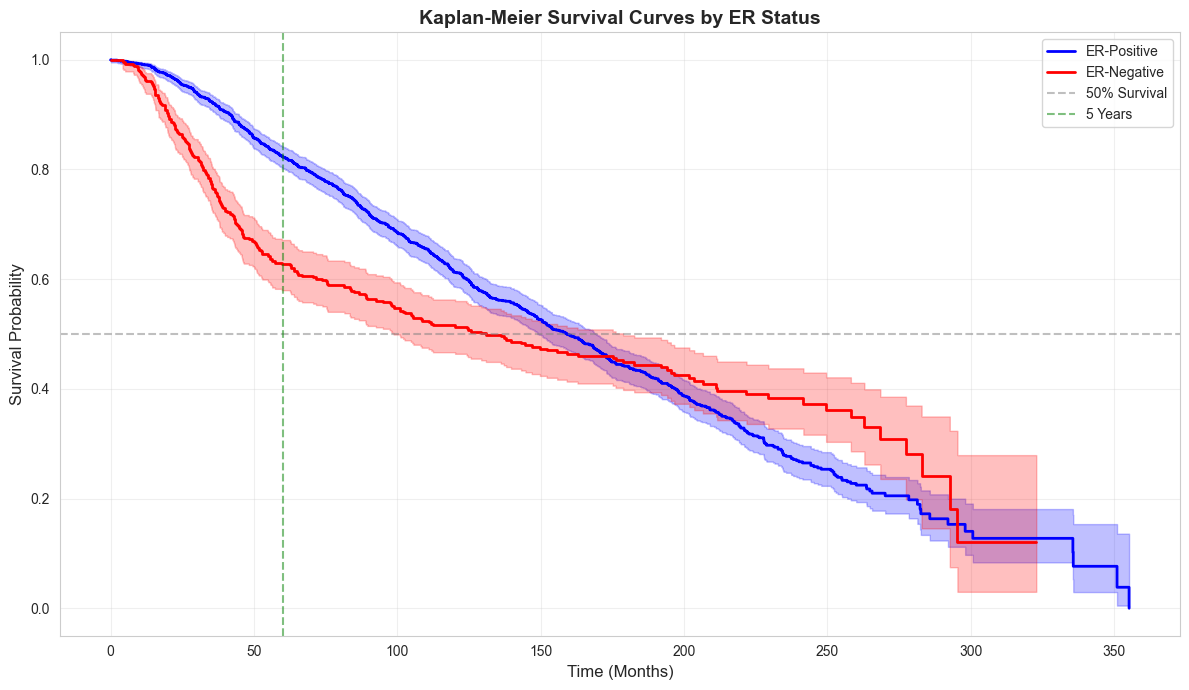


5-Year Survival Rates (at 60 months):
  ER-Positive: 82.3%
  ER-Negative: 62.8%

Median Survival Times:
  ER-Positive: 159.23 months
  ER-Negative: 130.87 months

Log-rank test p-value: 0.1102
The difference between groups is not statistically significant (α=0.05)


In [59]:

print("\n" + "="*80)
print("QUESTIONS 4-7: KAPLAN-MEIER CURVES BY ER STATUS")
print("="*80)

# Prepare data for survival analysis
# Create binary event indicator (1 = died, 0 = censored/alive)
df['event'] = (df["Patient's Vital Status"] != "Living").astype(int)

# Filter and create ER status groups
df_er = df[df['ER status measured by IHC'].isin(['Positve', 'Negative'])].copy()
df_er['ER_Status'] = df_er['ER status measured by IHC'].map({'Positve': 'ER-Positive', 'Negative': 'ER-Negative'})

# Kaplan-Meier analysis by ER status
kmf = KaplanMeierFitter()

plt.figure(figsize=(12, 7))

# ER-Positive group - remove NaN values
er_pos = df_er[df_er['ER_Status'] == 'ER-Positive'].copy()
er_pos = er_pos[er_pos['Overall Survival (Months)'].notna() & er_pos['event'].notna()]
print(f"\nER-Positive: {len(er_pos)} patients (after removing NaN)")

kmf.fit(er_pos['Overall Survival (Months)'], er_pos['event'], label='ER-Positive')
kmf.plot_survival_function(ci_show=True, color='blue', linewidth=2)
median_er_pos = kmf.median_survival_time_

# ER-Negative group - remove NaN values
er_neg = df_er[df_er['ER_Status'] == 'ER-Negative'].copy()
er_neg = er_neg[er_neg['Overall Survival (Months)'].notna() & er_neg['event'].notna()]
print(f"ER-Negative: {len(er_neg)} patients (after removing NaN)")

kmf.fit(er_neg['Overall Survival (Months)'], er_neg['event'], label='ER-Negative')
kmf.plot_survival_function(ci_show=True, color='red', linewidth=2)
median_er_neg = kmf.median_survival_time_

plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.title('Kaplan-Meier Survival Curves by ER Status', fontsize=14, fontweight='bold')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% Survival')
plt.axvline(x=60, color='green', linestyle='--', alpha=0.5, label='5 Years')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('km_curve_er_status.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate 5-year survival rates
kmf_pos = KaplanMeierFitter()
kmf_pos.fit(er_pos['Overall Survival (Months)'], er_pos['event'])
survival_5yr_pos = kmf_pos.predict(60) * 100

kmf_neg = KaplanMeierFitter()
kmf_neg.fit(er_neg['Overall Survival (Months)'], er_neg['event'])
survival_5yr_neg = kmf_neg.predict(60) * 100

print(f"\n5-Year Survival Rates (at 60 months):")
print(f"  ER-Positive: {survival_5yr_pos:.1f}%")
print(f"  ER-Negative: {survival_5yr_neg:.1f}%")

print(f"\nMedian Survival Times:")
print(f"  ER-Positive: {median_er_pos:.2f} months" if not np.isnan(median_er_pos) else "  ER-Positive: Not reached (>50% still alive)")
print(f"  ER-Negative: {median_er_neg:.2f} months" if not np.isnan(median_er_neg) else "  ER-Negative: Not reached (>50% still alive)")

if np.isnan(median_er_pos) or np.isnan(median_er_neg):
    print("\nNote: 'Not reached' means that more than 50% of patients in that group")
    print("are still alive at the end of the study period, so we cannot determine")
    print("the median survival time.")

# Log-rank test
results = logrank_test(er_pos['Overall Survival (Months)'], er_neg['Overall Survival (Months)'],
                       er_pos['event'], er_neg['event'])
print(f"\nLog-rank test p-value: {results.p_value:.4f}")
print(f"The difference between groups is {'statistically significant' if results.p_value < 0.05 else 'not statistically significant'} (α=0.05)")


Looks like ER-Positive patients had a longer survival time when looking at the median survival time.
However, when looking at the graph they converge around month 175, and then the ER-Negative had a higher chance of survival and then they finally converge again at month 290.

#### 8. Tumor Stage (0, 1, 2, 3, 4) - Create survival curves for each stage on one plot.


QUESTION 8: KAPLAN-MEIER CURVES BY TUMOR STAGE


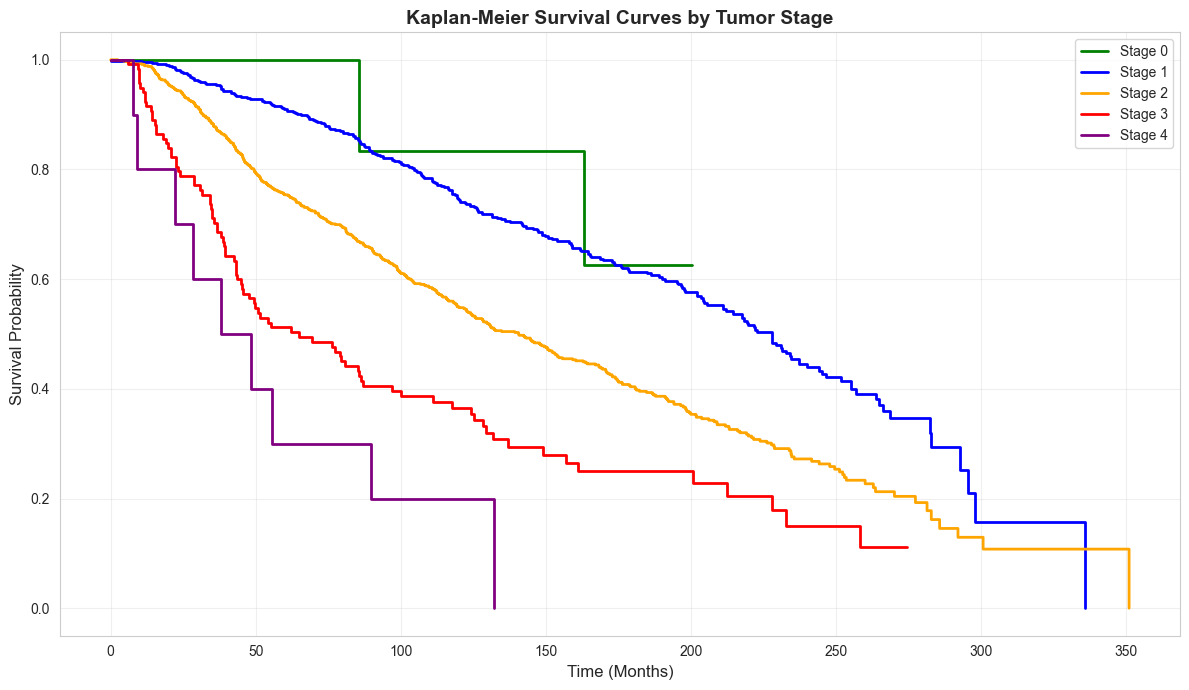


Median Survival Times by Stage:
  Stage 0: inf months
  Stage 1: 227.80 months
  Stage 2: 140.60 months
  Stage 3: 64.93 months
  Stage 4: 38.13 months

Pattern: Generally, higher tumor stages show worse survival outcomes.


In [60]:
print("\n" + "="*80)
print("QUESTION 8: KAPLAN-MEIER CURVES BY TUMOR STAGE")
print("="*80)

# Kaplan-Meier by Tumor Stage
df_stage = df[df['Tumor Stage'].notna()].copy()
stages = sorted(df_stage['Tumor Stage'].unique())

plt.figure(figsize=(12, 7))
colors = ['green', 'blue', 'orange', 'red', 'purple']

stage_medians = {}
for i, stage in enumerate(stages):
    stage_data = df_stage[df_stage['Tumor Stage'] == stage].copy()
    # Remove NaN values
    stage_data = stage_data[stage_data['Overall Survival (Months)'].notna() & stage_data['event'].notna()]
    
    if len(stage_data) > 0:  # Only fit if there's data
        kmf.fit(stage_data['Overall Survival (Months)'], stage_data['event'], 
                label=f'Stage {int(stage)}')
        kmf.plot_survival_function(ci_show=False, color=colors[i % len(colors)], linewidth=2)
        stage_medians[int(stage)] = kmf.median_survival_time_

plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.title('Kaplan-Meier Survival Curves by Tumor Stage', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('km_curve_tumor_stage.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMedian Survival Times by Stage:")
for stage, median in stage_medians.items():
    if not np.isnan(median):
        print(f"  Stage {stage}: {median:.2f} months")
    else:
        print(f"  Stage {stage}: Not reached")

print("\nPattern: Generally, higher tumor stages show worse survival outcomes.")


#### 9. Age groups: Create three groups based on age at diagnosis. Young: Under 50 years, Middle: 50-70 years, Older: Over 70 year


QUESTION 9: KAPLAN-MEIER CURVES BY AGE GROUP


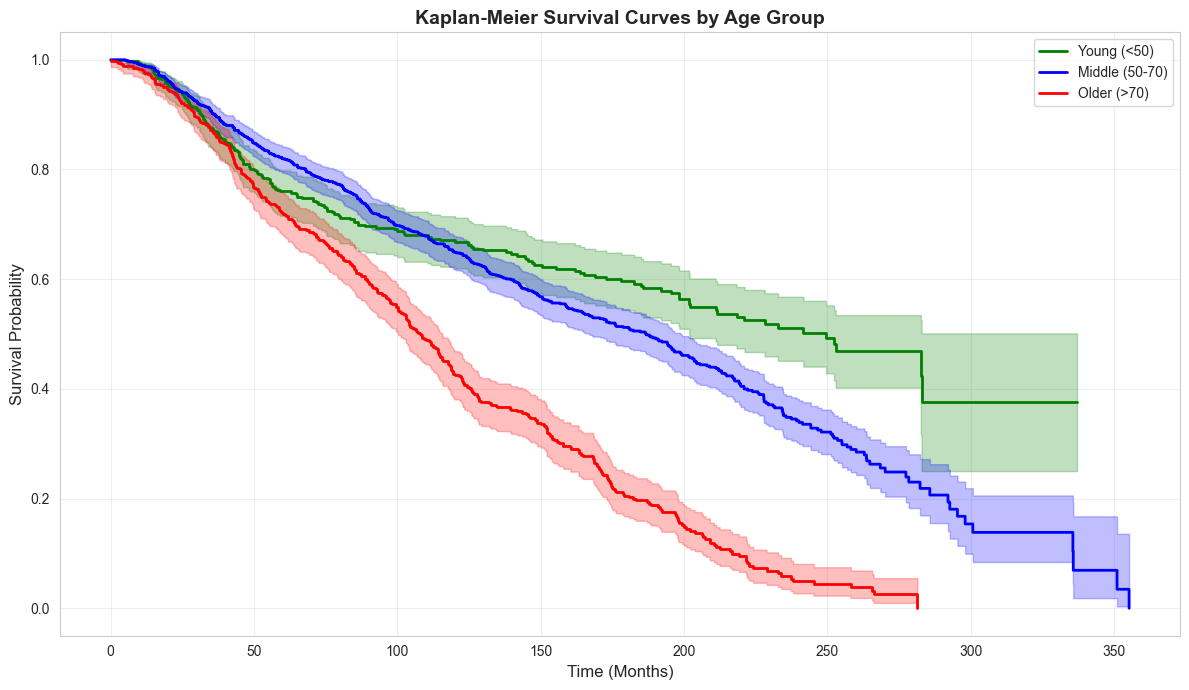


Median Survival Times by Age Group:
  Young (<50): 249.53 months
  Middle (50-70): 186.83 months
  Older (>70): 107.77 months

Pattern: Typically, younger patients have better survival outcomes,
while older patients (>70) may have worse outcomes due to age-related factors.


In [61]:
print("\n" + "="*80)
print("QUESTION 9: KAPLAN-MEIER CURVES BY AGE GROUP")
print("="*80)

# Create age groups
df['Age_Group'] = pd.cut(df['Age at Diagnosis'], 
                         bins=[0, 50, 70, 150], 
                         labels=['Young (<50)', 'Middle (50-70)', 'Older (>70)'])

plt.figure(figsize=(12, 7))
colors_age = ['green', 'blue', 'red']

age_medians = {}
for i, age_group in enumerate(['Young (<50)', 'Middle (50-70)', 'Older (>70)']):
    age_data = df[df['Age_Group'] == age_group].copy()
    # Remove NaN values
    age_data = age_data[age_data['Overall Survival (Months)'].notna() & age_data['event'].notna()]
    
    if len(age_data) > 0:  # Only fit if there's data
        kmf.fit(age_data['Overall Survival (Months)'], age_data['event'], label=age_group)
        kmf.plot_survival_function(ci_show=True, color=colors_age[i], linewidth=2)
        age_medians[age_group] = kmf.median_survival_time_

plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.title('Kaplan-Meier Survival Curves by Age Group', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('km_curve_age_group.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMedian Survival Times by Age Group:")
for age_group, median in age_medians.items():
    if not np.isnan(median):
        print(f"  {age_group}: {median:.2f} months")
    else:
        print(f"  {age_group}: Not reached")

print("\nPattern: Typically, younger patients have better survival outcomes,")
print("while older patients (>70) may have worse outcomes due to age-related factors.")


#### 10. For both 9 and 10, describe what patterns you see. Which groups have the best and worst survival

In [62]:
print('Looks like stage 0, and young patients have the best rate of survival. Stage 4, and older patients have the worst survival.')

Looks like stage 0, and young patients have the best rate of survival. Stage 4, and older patients have the worst survival.


#### 11. Fit a Cox proportional hazards model to predict overall survival using these variables: Age at Diagnosis, Tumor Size, Tumor Stage, ER Status, Chemotherapy
#### 12. Report the hazard ratio for each variable. Which variables have hazard ratios greater than 1 (indicating increased risk)?


QUESTIONS 11-12: COX PROPORTIONAL HAZARDS MODEL

Cox Proportional Hazards Model Summary:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
Age           0.040972   1.041823  0.003541        0.034032        0.047913   
TumorSize     0.008901   1.008941  0.002190        0.004610        0.013193   
TumorStage    0.337905   1.402008  0.067047        0.206496        0.469315   
ER_Positive  -0.287479   0.750153  0.094749       -0.473183       -0.101774   
Chemotherapy  0.352009   1.421921  0.119187        0.118407        0.585611   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to          z  \
covariate                                                                   
Age                      1.034618             1.049079     0.0  11.570343   
TumorSize                1.004620             1.013280     0.0   4.065143   
TumorStage               1.229362             1.

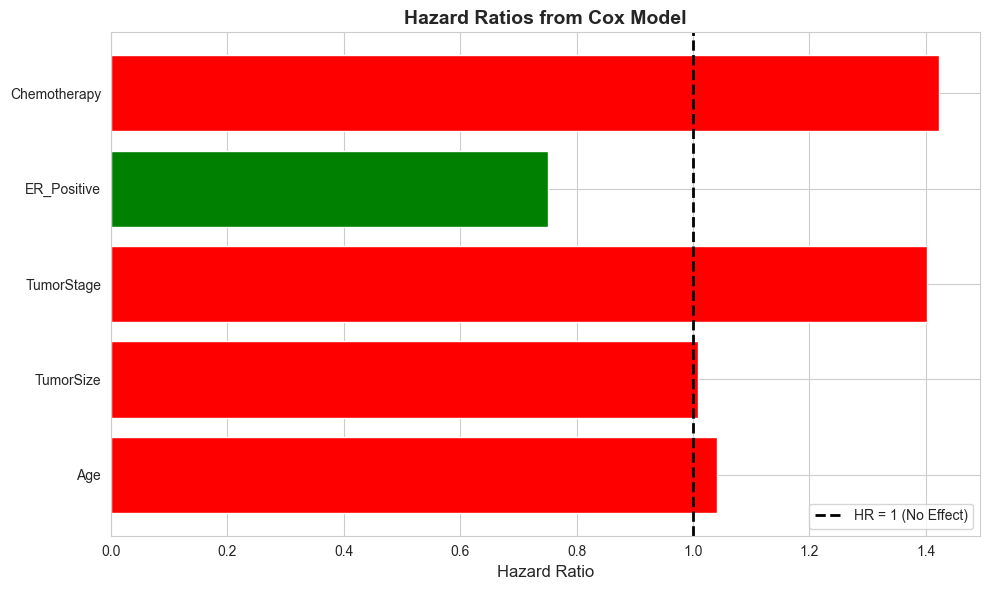

In [63]:

print("\n" + "="*80)
print("QUESTIONS 11-12: COX PROPORTIONAL HAZARDS MODEL")
print("="*80)

# Prepare data for Cox model
df_cox = df.copy()

# Clean and prepare variables
df_cox['ER_Status_Binary'] = (df_cox['ER status measured by IHC'] == 'Positve').astype(int)
df_cox['Chemo_Binary'] = (df_cox['Chemotherapy'] == 'Yes').astype(int)

# Select complete cases for Cox model
cox_vars = ['Age at Diagnosis', 'Tumor Size', 'Tumor Stage', 'ER_Status_Binary', 'Chemo_Binary']
df_cox_clean = df_cox[cox_vars + ['Overall Survival (Months)', 'event']].dropna()

# Rename for clearer output
df_cox_clean = df_cox_clean.rename(columns={
    'Age at Diagnosis': 'Age',
    'Tumor Size': 'TumorSize',
    'Tumor Stage': 'TumorStage',
    'ER_Status_Binary': 'ER_Positive',
    'Chemo_Binary': 'Chemotherapy',
    'Overall Survival (Months)': 'duration'
})

# Fit Cox model
cph = CoxPHFitter()
cph.fit(df_cox_clean, duration_col='duration', event_col='event')

print("\nCox Proportional Hazards Model Summary:")
print(cph.summary)

print("\n" + "="*80)
print("HAZARD RATIOS AND INTERPRETATION:")
print("="*80)

hr_df = pd.DataFrame({
    'Variable': cph.summary.index,
    'Hazard Ratio': np.exp(cph.summary['coef']),
    'HR 95% CI Lower': np.exp(cph.summary['coef'] - 1.96 * cph.summary['se(coef)']),
    'HR 95% CI Upper': np.exp(cph.summary['coef'] + 1.96 * cph.summary['se(coef)']),
    'P-value': cph.summary['p']
})

print("\n" + hr_df.to_string(index=False))

print("\n\nInterpretation:")
for idx, row in hr_df.iterrows():
    var = row['Variable']
    hr = row['Hazard Ratio']
    p_val = row['P-value']
    
    risk_direction = "INCREASED" if hr > 1 else "DECREASED"
    significance = "statistically significant" if p_val < 0.05 else "not significant"
    
    print(f"\n{var}:")
    print(f"  Hazard Ratio: {hr:.3f}")
    print(f"  Effect: {risk_direction} risk of death")
    print(f"  Significance: {significance} (p={p_val:.4f})")
    
    if hr > 1:
        print(f"  Interpretation: Each unit increase in {var} increases the hazard by {(hr-1)*100:.1f}%")
    else:
        print(f"  Interpretation: Each unit increase in {var} decreases the hazard by {(1-hr)*100:.1f}%")

# Plot hazard ratios
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(hr_df))
plt.barh(y_pos, hr_df['Hazard Ratio'], color=['red' if hr > 1 else 'green' for hr in hr_df['Hazard Ratio']])
plt.yticks(y_pos, hr_df['Variable'])
plt.axvline(x=1, color='black', linestyle='--', linewidth=2, label='HR = 1 (No Effect)')
plt.xlabel('Hazard Ratio', fontsize=12)
plt.title('Hazard Ratios from Cox Model', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
# plt.savefig('hazard_ratios.png', dpi=300, bbox_inches='tight')
plt.show()

#### 13. Using your Cox model from Question 12, calculate risk scores for these three patients:
| Patient   | Age | Tumor Size (mm) | Stage | ER Status   | Chemotherapy |
|-----------|-----|------------------|-------|-------------|--------------|
| Patient A | 45  | 15               | 1     | Positive    | No           |
| Patient B | 65  | 30               | 2     | Positive    | Yes          |
| Patient C | 55  | 25               | 2     | Negative    | Yes          |



QUESTION 13: RISK SCORES FOR THREE PATIENTS

Patient Characteristics:
           Age  TumorSize  TumorStage  ER_Positive  Chemotherapy
Patient A   45         15           1            1             0
Patient B   65         30           2            1             1
Patient C   55         25           2            0             1

RISK SCORES:

Patient A: 0.3228

Patient B: 1.6690

Patient C: 1.4127

Interpretation:
Risk scores are relative to the baseline hazard.
Higher values indicate higher risk of death.

Risk Comparison:
Patient A: Baseline (reference)
Patient B: 5.17x the risk of Patient A
Patient C: 4.38x the risk of Patient A


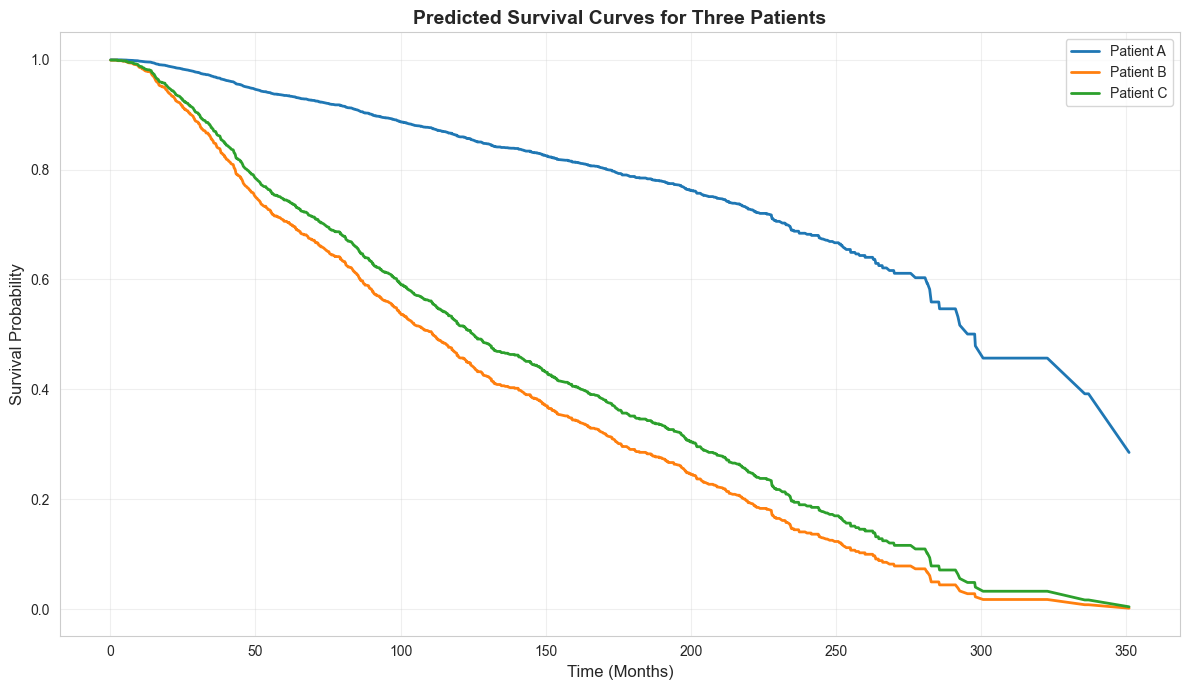

In [64]:
print("\n" + "="*80)
print("QUESTION 13: RISK SCORES FOR THREE PATIENTS")
print("="*80)

# Define three patients
patients = pd.DataFrame({
    'Age': [45, 65, 55],
    'TumorSize': [15, 30, 25],
    'TumorStage': [1, 2, 2],
    'ER_Positive': [1, 1, 0],  # 1=Positive, 0=Negative
    'Chemotherapy': [0, 1, 1],  # 1=Yes, 0=No
}, index=['Patient A', 'Patient B', 'Patient C'])

print("\nPatient Characteristics:")
print(patients)

# Calculate risk scores
risk_scores = cph.predict_partial_hazard(patients)

print("\n" + "="*80)
print("RISK SCORES:")
print("="*80)
for patient, score in risk_scores.items():
    print(f"\n{patient}: {score:.4f}")
    
print("\nInterpretation:")
print("Risk scores are relative to the baseline hazard.")
print("Higher values indicate higher risk of death.")

# Compare patients
print(f"\nRisk Comparison:")
baseline = risk_scores.iloc[0]
for i, (patient, score) in enumerate(risk_scores.items()):
    if i == 0:
        print(f"{patient}: Baseline (reference)")
    else:
        relative_risk = score / baseline
        print(f"{patient}: {relative_risk:.2f}x the risk of Patient A")

# Predict survival curves for each patient
plt.figure(figsize=(12, 7))
for patient in patients.index:
    surv_func = cph.predict_survival_function(patients.loc[[patient]])
    plt.plot(surv_func.index, surv_func.values[:, 0], linewidth=2, label=patient)

plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.title('Predicted Survival Curves for Three Patients', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('predicted_survival_curves.png', dpi=300, bbox_inches='tight')
plt.show()